# Классификация еды
Работу выполнил студент группы ФН12-33(М) Масягин Михаил

Подключение основных пакетов:

In [1]:
import os
import random

import cv2
from imutils import paths
from matplotlib import pyplot as plt
import numpy as np
import six
import tensorflow as tf

%matplotlib inline

Обработчик фотографий:

In [2]:
class Preprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
            self.width = width
            self.height = height
            self.inter = inter
            
    def preprocess(self, image):
            return cv2.resize(image, (self.width, self.height), interpolation = self.inter) 

Загрузчик фотографий:

In [3]:
class DatasetLoader:
    def __init__(self,preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []
            
    def load(self, imagePaths):
        data = []
        labels = []
        for imagePath in imagePaths:
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = imagePath.split(os.path.sep)[-2]
            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)
            data.append(image)
            labels.append(label)
        return(np.array(data),np.array(labels))

Нейронная сеть ResNet-18/34/50/101/152:

In [4]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def _bn_relu(inp):
    norm = BatchNormalization(axis=CHANNEL_AXIS)(inp)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(inp):
        activation = _bn_relu(inp)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(inp, residual):
    input_shape = K.int_shape(inp)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = inp
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(inp)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    def f(inp):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            inp = block_function(filters=filters, init_strides=init_strides,
                                 is_first_block_of_first_layer=(is_first_layer and i == 0))(inp)
        return inp

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    def f(inp):

        if is_first_block_of_first_layer:
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(inp)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(inp)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(inp, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    def f(inp):
        if is_first_block_of_first_layer:
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(inp)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(inp)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(inp, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        if K.image_data_format() == 'channels_last':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        block_fn = _get_block(block_fn)

        inp = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(inp)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        block = _bn_relu(block)

        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=inp, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

    @staticmethod
    def build_resnet(input_shape, num_outputs, n):
        if n == 18:
            return ResnetBuilder.build_resnet_18(input_shape, num_outputs)
        elif n == 34:
            return ResnetBuilder.build_resnet_34(input_shape, num_outputs)
        elif n == 50:
            return ResnetBuilder.build_resnet_50(input_shape, num_outputs)
        elif n == 101:
            return ResnetBuilder.build_resnet_101(input_shape, num_outputs)
        elif n == 152:
            return ResnetBuilder.build_resnet_152(input_shape, num_outputs)
        else:
            return ResnetBuilder.build_resnet_18(input_shape, num_outputs)

        
K.set_image_data_format('channels_last')

Визуализация тренировочных данных:

In [5]:
def visual(X_train, Y_train):
    index = np.random.choice(np.arange(len(X_train)), 24, replace=False)
    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16,9))
    for item in zip(axes.ravel(),X_train[index], Y_train[index]):
        axes, image, target = item
        axes.imshow(image)
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(target)
    plt.show() 

Анализ ошибок предсказаний:

In [6]:
def incorrect(X_test, Y_test, pred):
    food = ('Bread', 'Dessert', 'Meat', 'Soup')
    incorrect_predictions = []
    for i,(p,e) in enumerate(zip(pred,Y_test)):
        predicted, expected = np.argmax(p), np.argmax(e)
        if predicted != expected:
            incorrect_predictions.append((i, X_test[i], predicted, expected))
    print(len(incorrect_predictions))
    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16,12))
    for item in zip(axes.ravel(), incorrect_predictions):
        axes, inc_pred = item
        axes.imshow(inc_pred[1])
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(f'p: {food[inc_pred[2]]}; e: {food[inc_pred[3]]}')
    plt.show() 
    confusion = tf.math.confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
    print(confusion)

Визуализаций ошибок предсказаний:

In [7]:
def visual_incorrect(Epochs, Hist):
    # From second epoch, because error on 0 and 1 are too big.
    N = np.arange(2, Epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, Hist.history["loss"][2:], label = "train_loss")
    plt.plot(N, Hist.history["val_loss"][2:], label = "val_loss")
    plt.plot(N, Hist.history["accuracy"][2:], label = "train_acc")
    plt.plot(N, Hist.history["val_accuracy"][2:], label = "val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch №")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

Подготовка тестовых данных:

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

imagePaths = list(paths.list_images('/home/mikhail/classification/Food'))
random.seed(256)
random.shuffle(imagePaths)
input_width = 128
sp = Preprocessor(input_width, input_width)
dsl = DatasetLoader(preprocessors = [sp])
(data, labels) = dsl.load(imagePaths)
data = data.astype('float32')/255
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=256)

In [9]:
print('Train:',
      np.count_nonzero(trainY == 'Meat') / trainY.size,
      np.count_nonzero(trainY == 'Soup') / trainY.size,
      np.count_nonzero(trainY == 'Bread') / trainY.size,
      np.count_nonzero(trainY == 'Dessert') / trainY.size)
print('Test:',
      np.count_nonzero(testY == 'Meat') / testY.size,
      np.count_nonzero(testY == 'Soup') / testY.size,
      np.count_nonzero(testY == 'Bread') / testY.size,
      np.count_nonzero(testY == 'Dessert') / testY.size)

Train: 0.27141203703703703 0.23070987654320987 0.2629243827160494 0.2349537037037037
Test: 0.26985350809560527 0.23438704703161142 0.27833461835003853 0.2174248265227448


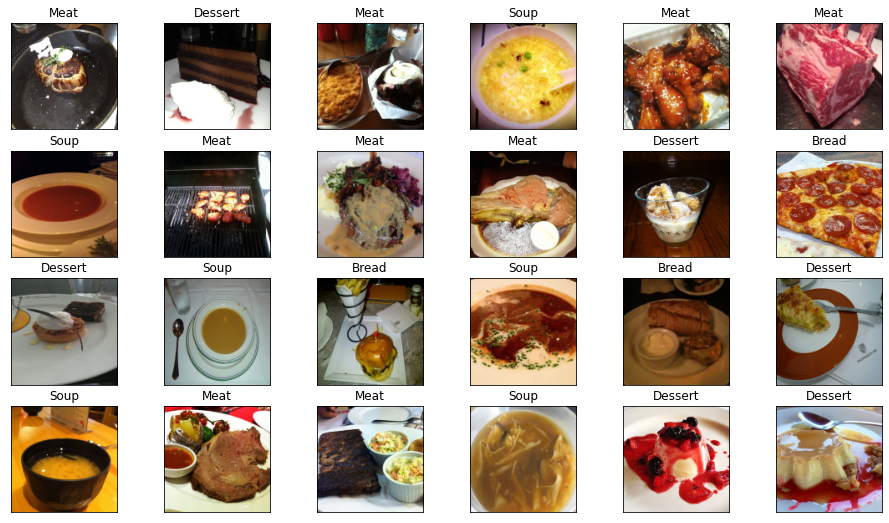

In [10]:
visual(trainX, trainY)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10.0, width_shift_range=0.10, height_shift_range=0.10, shear_range=0.10, zoom_range=0.10, horizontal_flip=True, vertical_flip=True)

Создание нейронной сети:

In [11]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, TensorBoard

lr_reducer = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=8, min_lr=0.5e-6, verbose=1)
early_stopper = EarlyStopping(min_delta=0.0005, patience=10, verbose=1)
csv_logger = CSVLogger('./resnet34_food.csv')
tb = TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)
    
model = ResnetBuilder.build_resnet((3, input_width, input_width), 4, 34)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Обучение нейронной сети:

In [12]:
epochs = 100
batch_size = 64
H = model.fit(datagen.flow(trainX, trainY), epochs=epochs, validation_data=(testX, testY), verbose=1, callbacks=[lr_reducer, early_stopper, csv_logger, tb])
model.save_weights('./food_weights.hdf5')

/home/mikhail/.local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
162/162 [==============================] - 43s 207ms/step - loss: 2.6289 - accuracy: 0.4838 - val_loss: 3.2554 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 32s 198ms/step - loss: 1.9057 - accuracy: 0.5471 - val_loss: 2.1266 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 32s 199ms/step - loss: 1.5602 - accuracy: 0.5766 - val_loss: 1.7301 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 32s 198ms/step - loss: 1.3775 - accuracy: 0.5920 - val_loss: 1.8160 - val_accuracy: 0.4426 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 32s 198ms/step - loss: 1.2794 - accuracy: 0.6125 - val_loss: 1.8289 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 32s 194ms/step - loss: 1.2178 - accuracy: 0.6208 - val_loss: 1.7325 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 7/100
162/162 [=========================

Epoch 50/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5816 - accuracy: 0.8208 - val_loss: 0.7204 - val_accuracy: 0.7710 - lr: 1.0000e-05
Epoch 51/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5702 - accuracy: 0.8239 - val_loss: 0.7181 - val_accuracy: 0.7764 - lr: 1.0000e-05
Epoch 52/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5669 - accuracy: 0.8264 - val_loss: 0.7217 - val_accuracy: 0.7733 - lr: 1.0000e-05
Epoch 53/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5690 - accuracy: 0.8239 - val_loss: 0.7143 - val_accuracy: 0.7687 - lr: 1.0000e-05
Epoch 54/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5725 - accuracy: 0.8216 - val_loss: 0.7219 - val_accuracy: 0.7702 - lr: 1.0000e-05
Epoch 55/100
162/162 [==============================] - 32s 195ms/step - loss: 0.5766 - accuracy: 0.8206 - val_loss: 0.7287 - val_accuracy: 0.7695 - lr: 1.0000e-05
Epoch 56/100
162

Анализ нейронной сети:

41/41 [==============================] - 3s 65ms/step - loss: 0.7144 - accuracy: 0.7726
[0.7143819332122803, 0.7725520133972168]
0:0.0200137190%
1:0.0183554293%
2:4.4579755515%
3:95.5036640167%
295


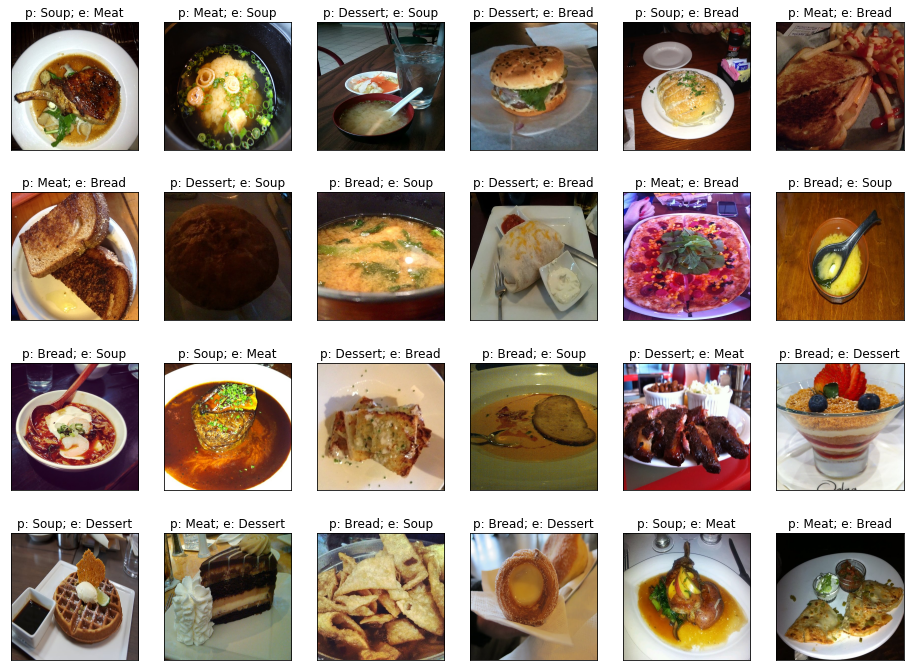

tf.Tensor(
[[255  47  52   7]
 [ 28 209  31  14]
 [ 21  43 280   6]
 [ 15  19  12 258]], shape=(4, 4), dtype=int32)


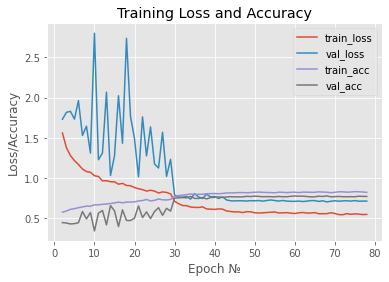

In [14]:
model.load_weights('./food_weights.hdf5')
results = model.evaluate(testX, testY)
print(results)
predictions = model.predict(testX)
for index, probability in enumerate(predictions[0]):
    print(f'{index}:{probability:.10%}')
incorrect(testX, testY, predictions)
visual_incorrect(79, H)